In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score)
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py

houston18_file = h5py.File('/content/drive/MyDrive/proje/Houston18.mat', 'r')
houston18_gt_file = h5py.File('/content/drive/MyDrive/proje/Houston18_7gt.mat', 'r')

data = np.array(houston18_file['ori_data'])
gt = np.array(houston18_gt_file['map'])

In [ ]:
def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX

In [ ]:


data = np.transpose(data, (1, 2, 0))

In [ ]:
data=applyPCA(data)

In [ ]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values

In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LFDA
from sklearn.impute import SimpleImputer

acc_list = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lfda = LFDA(k=2)
knn = KNeighborsClassifier(n_neighbors=5)

fold_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {fold_index} -> Train: {len(train_index)}, Test: {len(test_index)}")


    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lfda.fit(X_train, y_train)
    knn.fit(lfda.transform(X_train), y_train)


    lfda_acc = knn.score(lfda.transform(X_test), y_test)
    print('lfda accuracy {}'.format( lfda_acc))

    acc_list.append(lfda_acc)

    fold_index += 1

# **Test İşlemi ve Görselleştirme**

In [ ]:
import joblib

In [ ]:
joblib.dump(lfda, 'lfda_houston_model.pkl')
joblib.dump(knn,'lfda_houston_knn_model.pkl')

['lfda_houston_model.pkl']

In [ ]:
lfda_loaded = joblib.load('lfda_houston_model.pkl')
knn_loaded =joblib.load('lfda_houston_knn_model.pkl')

lfda_data=lfda_loaded.transform(X)
pred=knn_loaded.predict(lfda_data)

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

accuracy: 0.9412218045112782
cohen kappa: 0.9017544010504263
f1 score: 0.9193062578980052


In [ ]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


In [ ]:
i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

In [ ]:
gt_2=gt_2.reshape(data.shape[0],-1)

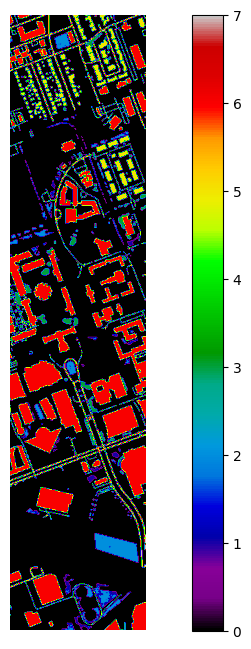

In [ ]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

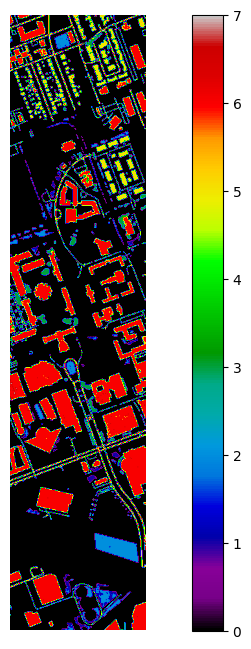

In [ ]:
plot_gt(gt_2)